In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mnist_utils
import random
import relu_utils as alg
import spiking_relu as sr
import copy
import scipy

In [2]:
cell_params_lif = {'cm': 0.25,      #nF
                   'i_offset': 0.1, #nA
                   'tau_m': 20.0,   #ms
                   'tau_refrac': 1.,#ms
                   'tau_syn_E': 5.0,#ms
                   'tau_syn_I': 5.0,#ms
                   'v_reset': -65.0,#mV
                   'v_rest': -65.0, #mV
                   'v_thresh': -50.0#mV
                   }

#Figure 1: Physics measurement of noisy current
Implement sigert in python

mi = 0.8
si = 0.2
C = 1. #cell_params_lif['cm']
mu = mi/C
sigma = np.sqrt(2.) * si / C
print mu, sigma

In [3]:
from scipy.integrate import quad
import bigfloat
def integerf(t):
    return bigfloat.exp(-t**2., bigfloat.precision(100))

# def integrand(u):
#     exp_u = bigfloat.exp(u**2.,bigfloat.precision(100))
#     pi = bigfloat.sqrt(np.pi,bigfloat.precision(100))
#     erf_u = quad(integerf, 0, u)[0]
#     return pi*exp_u*(2./pi * erf_u+1.) #pi*exp_u*(erf(u)+1.)
    
def integrand(u):
    from scipy.special import erfcx
#     print erfcx(u)
    return np.sqrt(np.pi) * erfcx(-u)
#     from scipy.special import erf
#     return np.sqrt(np.pi) * np.exp(u**2) * (erf(u)+1.)
    
def responsefunc(mu, sigma, cell_para):
    offset = 0.00
    
    vr = cell_para['v_rest']/1000.
    vth = cell_para['v_thresh']/1000. - vr + offset
    vr = offset
    tau = cell_para['tau_m']/1000.
    tau_r = cell_para['tau_refrac']/1000.
#     vr=9.9/1000.
#     vth=20./1000.
#     tau=26.3/1000.
#     tau_r=9.4/1000.
    vr_hat = (vr - mu*tau)/(sigma*np.sqrt(tau))
    vth_hat = (vth - mu*tau)/(sigma*np.sqrt(tau))
    
#     print vr_hat, vth_hat
    integ = quad(integrand, vr_hat, vth_hat)[0]
    
    return 1./(tau_r + tau*integ)

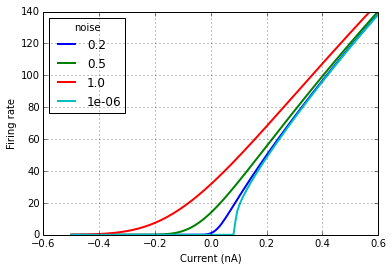

In [11]:
C = cell_params_lif['cm']
x = np.arange(-0.5,0.6,0.007)
sigma = np.array([0.2, 0.5, 1, 0.000001])
y = np.zeros((x.size,sigma.size))
for j in range(sigma.size):
    for i in range(x.size):
        y[i][j] = responsefunc((0.1+x[i])/C, np.sqrt(10**-3)*sigma[j]/C, cell_params_lif)
#         y[i][j] = responsefunc(x[i], np.sqrt(2.)*sigma[j], cell_params_lif)
curve = plt.plot(x,y,linewidth=2)

plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.ylim((0,140))
plt.legend(curve, sigma, title='noise', loc='upper left') #, shadow=True loc='upper left'
plt.savefig('pic/1.pdf')

In [ ]:
np.log()

#Figure 2: noisy_current against firing rate

A Gaussian “white” noise current source. The current amplitude changes at fixed intervals, with the new value drawn from a Gaussian distribution.

Required arguments:

    mean:
        mean current amplitude in nA
    stdev:
        standard deviation of the current amplitude in nA



In [5]:
def noise_current(current, stdnoise, cell_params_lif, trial):
    import pyNN.nest as p
    runtime = 10000.
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    poplist = []
    ratelist = np.zeros(trial)
    for i in range(trial):
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        noise = p.NoisyCurrentSource(mean=current, stdev=stdnoise, start=0, stop=runtime, dt=1.0,rng=p.NativeRNG(seed=i))
        noise.inject_into(pop)
        pop.record()
        poplist.append(pop)
    p.run(runtime)
    for i in range(trial):
        spikes = poplist[i].getSpikes(compatible_output=True)
        ratelist[i] = len(spikes)*1000./runtime
    p.end()
    return ratelist.mean(), ratelist.max(), ratelist.min()

In [6]:
trial = 10
stdnoise = np.array([0.2, 0.5, 1.])
current =  np.arange(-0.5,0.65,0.1)
# current = np.append(current, np.arange(0.5,1.2,0.2))

x_num = current.size
noise_num = stdnoise.size
rate_mean = np.zeros((x_num, stdnoise.size))
rate_max = np.zeros((x_num, stdnoise.size))
rate_min = np.zeros((x_num, stdnoise.size))
for j in range(noise_num):
    for i in range(x_num):
        rate_mean[i,j], rate_max[i,j], rate_min[i,j] = noise_current(current[i], stdnoise[j], cell_params_lif,trial)
#plt.plot(current, rate_mean, 'green')
#plt.fill_between(current, rate_min, rate_max, facecolor='green', alpha=0.5, interpolate=True)

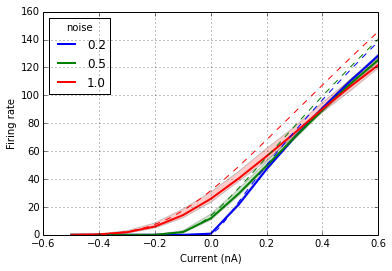

In [41]:
curve = plt.plot(current, rate_mean, linewidth=2)
for i in range(len(curve)):
    c = plt.getp(curve[i],'color')
    plt.fill_between(current, rate_min[:,i], rate_max[:,i], facecolor=c, alpha=0.2, interpolate=True)
    plt.plot(x,y[:,i],linestyle='dashed',linewidth=1,color=c)
plt.grid('on')

plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
plt.legend(curve, stdnoise, title='noise', loc='upper left') #, shadow=True loc='upper left'
plt.savefig('pic/2.pdf')

#Figure 3: noisy current generated by Poisson spikes vs. firing rate
y_noise = np.sqrt(signal.convolve2d(abs(xi),np.transpose(w**2.),mode='valid'))

In [5]:
def gen_spikesource(num, dur, rate):
    from mnist_utils import poisson_generator
    spike_source_data = [[] for i in range(num)]
    for i in range(num):
        t_start = 0
        t_stop = dur
        spikes = poisson_generator(rate, t_start, t_stop)
        if spikes != []:
            spike_source_data[i].extend(spikes)
    return spike_source_data

In [6]:
def noise_poisson(mu, sigma, trial):
    import pyNN.nest as p
    runtime = 10000.
    p.setup(timestep=1.0, min_delay=1.0, max_delay=16.0)
    
    num = 500
    w = 0.05
    
    rate_sub = mu/w
    rate_sum = 2.*sigma**2./w**2.
    
    rate1 = (rate_sub + rate_sum)/2.
    rate2 = (rate_sum - rate1)
    rate1 = rate1 * 1000./cell_params_lif['tau_syn_E']/float(num)
    rate2 = rate2 * 1000./cell_params_lif['tau_syn_I']/float(num)
    poplist = []
    ratelist = np.zeros(trial)
    
    np.random.seed(0)
    for i in range(trial):
        spike_source_data1 = gen_spikesource(num, runtime, rate1)
        spike_source_data2 = gen_spikesource(num, runtime, rate2)
        pop = p.Population(1, p.IF_curr_exp, cell_params_lif)
        noise1 = p.Population(num,  p.SpikeSourceArray, {'spike_times' : []})
        noise2 = p.Population(num,  p.SpikeSourceArray, {'spike_times' : []})
        for j in range(num):
            noise1[j].spike_times = spike_source_data1[j]
            noise2[j].spike_times = spike_source_data2[j]
            
        ee_connector = p.AllToAllConnector(weights=w)
        in_connector = p.AllToAllConnector(weights=-w)
        p.Projection(noise1, pop, ee_connector, target='excitatory')
        p.Projection(noise2, pop, in_connector, target='inhibitory')
        pop.record()
        poplist.append(pop)
    p.run(runtime)
    for i in range(trial):
        spikes = poplist[i].getSpikes(compatible_output=True)
        ratelist[i] = len(spikes)*1000./runtime
    p.end()
    return ratelist.mean(), ratelist.max(), ratelist.min()

In [44]:
trial = 10
stdnoise = np.array([0.2, 0.5, 1.])
current =  np.arange(-0.5,0.65,0.1)
x_num = current.size
noise_num = stdnoise.size
rate_mean2 = np.zeros((x_num, stdnoise.size))
rate_max2 = np.zeros((x_num, stdnoise.size))
rate_min2 = np.zeros((x_num, stdnoise.size))
for j in range(noise_num):
    for i in range(x_num):
        rate_mean2[i,j], rate_max2[i,j], rate_min2[i,j] = noise_poisson(current[i], stdnoise[j],trial)

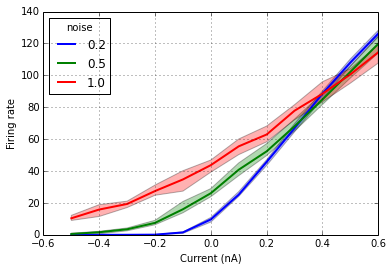

In [47]:
curve = plt.plot(current, rate_mean2, linewidth=2)
for i in range(len(curve)):
    c = plt.getp(curve[i],'color')
    plt.fill_between(current, rate_min2[:,i], rate_max2[:,i], facecolor=c, alpha=0.3, interpolate=True)
    #plt.plot(x,y[:,i],linestyle='dashed',linewidth=1,color=c)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
# plt.ylim((0,200))
plt.legend(curve, stdnoise, title='noise', loc='upper left') #, shadow=True loc='upper left'
plt.savefig('pic/3.pdf')

In [7]:
trial = 10
stdnoise = np.array([0.2, 0.5, 1.])
current =  np.arange(-0.5,0.65,0.1)
cell_params_lif = {'cm': 0.25,      #nF
                   'i_offset': 0.1, #nA
                   'tau_m': 20.0,   #ms
                   'tau_refrac': 1.,#ms
                   'tau_syn_E': 1.0,#ms
                   'tau_syn_I': 1.0,#ms
                   'v_reset': -65.0,#mV
                   'v_rest': -65.0, #mV
                   'v_thresh': -50.0#mV
                   }
x_num = current.size
noise_num = stdnoise.size
rate_mean3 = np.zeros((x_num, stdnoise.size))
rate_max3 = np.zeros((x_num, stdnoise.size))
rate_min3 = np.zeros((x_num, stdnoise.size))
for j in range(noise_num):
    for i in range(x_num):
        rate_mean3[i,j], rate_max3[i,j], rate_min3[i,j] = noise_poisson(current[i], stdnoise[j],trial)

In [8]:
cell_params_lif = {'cm': 0.25,      #nF
                   'i_offset': 0.1, #nA
                   'tau_m': 20.0,   #ms
                   'tau_refrac': 1.,#ms
                   'tau_syn_E': 5.0,#ms
                   'tau_syn_I': 5.0,#ms
                   'v_reset': -65.0,#mV
                   'v_rest': -65.0, #mV
                   'v_thresh': -50.0#mV
                   }

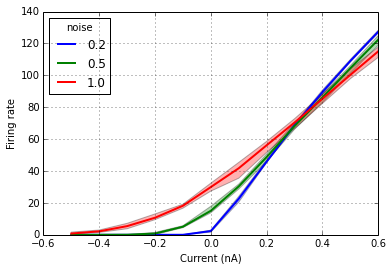

In [9]:
curve = plt.plot(current, rate_mean3, linewidth=2)
for i in range(len(curve)):
    c = plt.getp(curve[i],'color')
    plt.fill_between(current, rate_min3[:,i], rate_max3[:,i], facecolor=c, alpha=0.3, interpolate=True)
    #plt.plot(x,y[:,i],linestyle='dashed',linewidth=1,color=c)
plt.grid('on')
plt.xlabel('Current (nA)')
plt.ylabel('Firing rate')
# plt.ylim((0,200))
plt.legend(curve, stdnoise, title='noise', loc='upper left') #, shadow=True loc='upper left'
plt.savefig('pic/3-2.pdf')

#Figure 4: noisy_softplus vs. all the above with scaled output

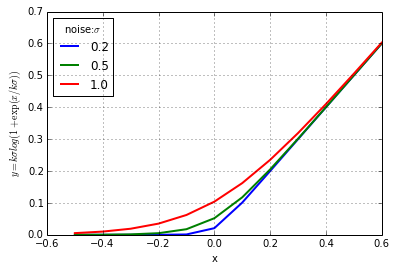

In [50]:
a = stdnoise*0.15
b = np.ones(a.size)/a
y = np.zeros((current.size, a.size))
for i in range(a.size):
    if a[i]>0:
        y[:,i] = a[i] * np.log(1+np.exp(b[i]*current))
    else:
        y[current>0,i] = current[current>0]
curve = plt.plot(current,y, linewidth=2)
plt.grid('on')
plt.xlabel('x')
plt.ylabel('$y=k\sigma log(1+\exp(x/k\sigma))$')
plt.legend(curve, stdnoise, title='noise:$\sigma$', loc='upper left') 
plt.savefig('pic/4.pdf')

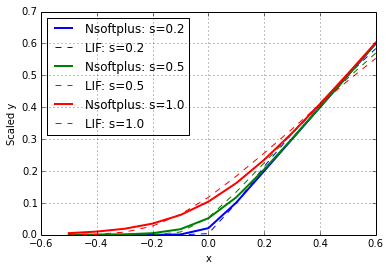

In [51]:
for i in range(stdnoise.size):
    tmp = plt.plot(current,y[:,i], linewidth=2, label='Nsoftplus: s=%.1f'%stdnoise[i])
    c = plt.getp(tmp[0],'color')
    plt.plot(current, rate_mean[:,i]/220., color=c, linestyle='dashed',linewidth=1,  label='LIF: s=%.1f'%stdnoise[i])
plt.grid('on')
plt.xlabel('x')
plt.ylabel('Scaled y')
plt.legend(loc='upper left') 
#plt.xlim((-0.5,0.5))
#plt.ylim((0,1))
#plt.legend(curve2, stdnoise, title='noise', loc='lower right') #, shadow=True loc='upper left'
plt.savefig('pic/4-2.pdf')

#Figure 5: noisy_softplus in 3D

/opt/ipython/IPython/kernel/__main__.py:10: RuntimeWarning: divide by zero encountered in divide


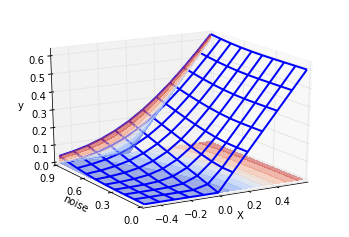

In [61]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.arange(-0.5, 0.61, 0.1)
y = np.arange(0,1,0.1)
X, Y = np.meshgrid(x, y)
a = Y*0.3
b = np.ones(a.shape)/a
Z = X.copy()
Z[Z<0] = 0
Z[a>0] = a[a>0] * np.log(1+np.exp(b[a>0]*X[a>0]))
#surf = ax.plot_surface(X, Y, Z,  rstride = 1, cstride =1, alpha=0.5, linewidth=0)
surf = ax.plot_wireframe(X, Y, Z, linewidth=2)
cset = ax.contourf(X, Y, Z, zdir='z', alpha=0.5, offset=0, cmap=cm.coolwarm)
#cset = ax.contourf(X, Y, Z, zdir='x', alpha=0.5,offset=-10, cmap=cm.coolwarm)
cset = ax.contourf(X, Y, Z, zdir='y', alpha=0.6,offset=0.9, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_ylabel('noise')
ax.set_yticks(np.arange(0,1,0.3))
ax.set_zlabel('y')
ax.view_init(azim = -120,elev = 20)
plt.savefig('pic/5.pdf')

#Figure 6: real application on 1-layer conv net

In [70]:
import cnn_utils as cnnu
w_cnn, l_cnn = cnnu.readmat('scale5.mat') #scale5.mat cnn_nsp0.023_9.mat scaled.mat
test_x, test_y = mnist_utils.get_test_data()
test_x /= 255.
dur_test = 1000
silence = 20


In [71]:
offset = 0
num_test = 10
test = test_x[offset:(offset+num_test), :]
import pyNN.nest as p
import scnn_sim as ss
p.setup(timestep=1.0, min_delay=1.0, max_delay=3.0)
L = l_cnn

random.seed(0)
input_size = L[0][1]
pops_list = []

pops_list.append(ss.init_inputlayer(input_size, test[:num_test, :] * 30., 0, dur_test, silence)) #max_F/max_sum
for l in range(5):
    pops_list.append(ss.construct_layer(pops_list[l], L[l+1][0], L[l+1][1], w_cnn[l], cell_params_lif))

k_index = 0
observe = pops_list[1][k_index] #[1][1] #[5][0]
inpop = pops_list[0][0]
result = pops_list[5][0]

observe.record()
inpop.record()
result.record()

p.run((dur_test+silence)*num_test)
spikes = observe.getSpikes(compatible_output=True)
spikein = inpop.getSpikes(compatible_output=True)
spike_result = result.getSpikes(compatible_output=True)
p.end()

1 6
6 6
6 12
12 12
10


In [72]:
def plot_digit(img_raw, size=28, crange=(0.0, 40.), filen=''):
    #img_raw = np.uint8(img_raw)
    plt.figure(figsize=(5,5))
    im = plt.imshow(np.reshape(img_raw,(size,size)), cmap=cm.gray_r,interpolation='none', clim=crange)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        right='off',
        labelleft='off')   
    plt.savefig(filen)
    plt.show()

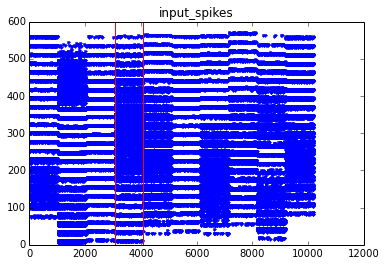

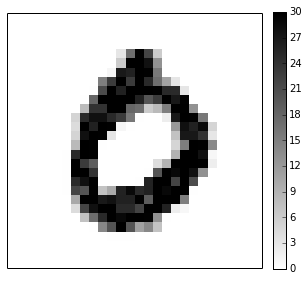

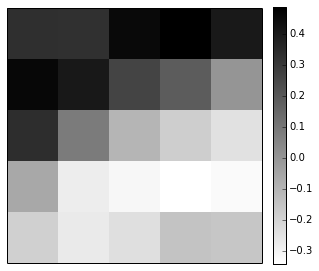

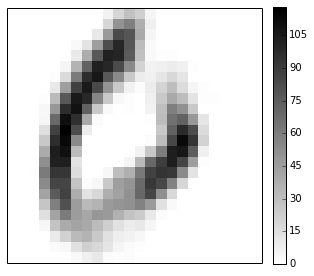

In [73]:
spike_count = ss.count_spikes(spikes, 24*24, num_test, dur_test, silence)
inspike_count = ss.count_spikes(spikein, 784, num_test, dur_test, silence)
spike_result_count = ss.count_spikes(spike_result, 10, num_test, dur_test, silence)
k_digit = 3
plt.plot([i[1] for i in spikes], [i[0] for i in spikes], ".", )
plt.title('input_spikes')
plt.plot([(dur_test+silence)*k_digit, (dur_test+silence)*k_digit], [0, 600], 'r')
plt.plot([(dur_test+silence)*(1+k_digit), (dur_test+silence)*(1+k_digit)], [0, 600], 'r')
plt.savefig('pic/6-1.png')


plot_digit(inspike_count[:,k_digit], 28, crange=(0,30), filen='pic/6-2.pdf')
#plt.savefig()
plot_digit(w_cnn[0][0][k_index], 5, crange=(w_cnn[0][0][k_index].min(), w_cnn[0][0][k_index].max()), filen='pic/6-3.pdf')
# plt.savefig()
plot_digit(spike_count[:,k_digit], 24, crange=(min(spike_count[:,k_digit]), max(spike_count[:,k_digit])), filen='pic/6-4.pdf')
# plt.savefig('pic/6-4.pdf')


In [74]:
def conv2d_noise(x, w, mode='c'):
    from scipy import signal
    if len(x.shape)== 2:
        input_size = np.sqrt(x.shape[1])
        for i in range(x.shape[0]):
            #xi = np.reshape(x[i],(input_size, input_size),order='F')
            xi = np.reshape(x[i],(input_size, input_size))
            y = signal.convolve2d(xi,np.transpose(w),mode='valid')
            y_noise = np.sqrt(signal.convolve2d(abs(xi),np.transpose(w**2.)/2.,mode='valid'))
            print np.max(y_noise), np.max(y)
            y = np.nan_to_num(y)
            if mode=='s':
                w_size = w.shape[0]
                y = y[0::w_size, 0::w_size]
            #y = np.reshape(y, (1, y.shape[0]*y.shape[0]),order='F')
            #y = relu(y)
            z = softplus_noise(y, y_noise)
            z = np.reshape(z, (1, z.shape[0]*z.shape[0]))
            y = np.reshape(y, (1, y.shape[0]*y.shape[0]))
            y_noise = np.reshape(y_noise, (1, y_noise.shape[0]*y_noise.shape[0]))
            if i==0:
                y_list = y
                z_list = z
                yn_list = y_noise
            else:
                y_list = np.append(y_list, y, axis=0)
                z_list = np.append(z_list, z, axis=0)
                yn_list = np.append(yn_list, y_noise, axis=0)
        return z_list, y_list, yn_list
    else:
        print 'x has to be an array of'
        return -1
def relu(x):
    x[x<0]=0
    return x

def softplus_noise(x, noise):
    #y = relu(x)
    y = x.copy()
    rows, cols = np.where(noise>0)
    for i in range(rows.shape[0]):
        y[rows[i]][cols[i]] = softplus(x[rows[i]][cols[i]], noise[rows[i]][cols[i]])
    
    return y

def softplus(x, noise):
    a = noise * 0.15 * np.sqrt(5)
    b = 1./a
    sfactor = 1.#49.66
    y = a * b * x * sfactor;
    if x<10:
        y = sfactor * a * np.log(1.+ np.exp(x*b))
    return y


0.338591707148 0.534323539505
0.361668263273 0.541295290785
0.312918039459 0.49453559067
0.392341451159 0.577154955109
0.359550780324 0.496892450981
0.338456552099 0.552755121286
0.34088795401 0.522268311167
0.368441101153 0.51492880773
0.385313384385 0.561186348666
0.379304820487 0.539369367425


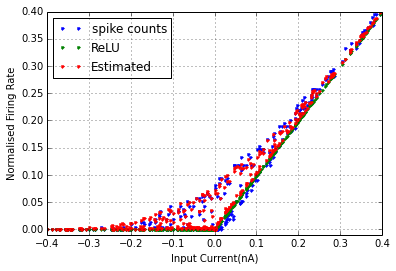

In [110]:
k_digit = 3
temp_r, orig_r, noise_r = conv2d_noise(np.transpose(inspike_count)*0.001*5., w_cnn[0][0][k_index]) #tauE = 5 = tauI#scaled to 5

tmp = np.copy(orig_r[k_digit])
tmp[tmp<0]=0
plt.plot(orig_r[k_digit],spike_count[:,k_digit]/210.,'.', label='spike counts') #/spike_count[:,k_digit].max()
plt.plot(orig_r[k_digit],tmp,'.', label='ReLU') #/spike_count[:,k_digit].max()
plt.plot(orig_r[k_digit], temp_r[k_digit],'r.', label='Estimated')#/temp_r[k_digit].max()
plt.grid('on')
plt.xlabel('Input Current(nA)')
plt.ylabel('Normalised Firing Rate')
plt.legend(loc='upper left')
plt.xlim((-0.4,0.4))
plt.ylim((-0.01,0.4))
# plt.savefig('2.pdf')
plt.savefig('pic/6-5.pdf')
plt.show()


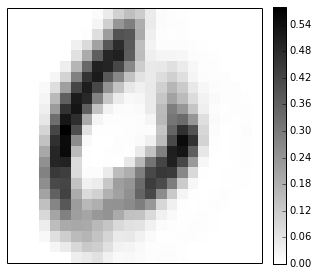

In [42]:
plot_digit(temp_r[k_digit], 24, crange=(np.min(temp_r[k_digit]),np.max(temp_r[k_digit])), filen='pic/6-x.pdf')
plot_digit(temp_r[k_digit], 24, crange=(np.min(temp_r[k_digit]),np.max(temp_r[k_digit])), filen='pic/6-x.pdf')

#Figure 7: real application using trained weights: result


[7 2 1 0 4 1 4 9 5 9] [  1.00000000e+00   4.29602713e-61   7.98490425e-30   6.21315959e-49
   9.46262947e-57   6.81355682e-46   1.10893902e-40   2.50656748e-46
   6.99199000e-56   2.03109266e-42]


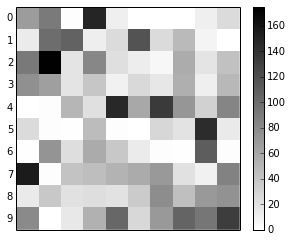

In [10]:
# plt.plot([i[1] for i in spike_result], [i[0] for i in spike_result], ".", )
# plt.title('output_spikes')
# plt.plot([3150, 3150], [0, 10], 'r')
# plt.plot([4200, 4200], [0, 10], 'r')
# plt.xlim((4000,4150))

im = plt.imshow(np.reshape(spike_result_count,(10,10)), cmap=cm.gray_r,interpolation='none') #[:,3]
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.yticks(range(10))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left='off',      # ticks along the bottom edge are off
    right='off')         # ticks along the top edge are off

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')
plt.savefig('pic/7.pdf')
exp_o = np.exp(spike_result_count[:, 3])
print spike_result_count.argmax(axis=0), exp_o/exp_o.sum()


#Figure 8: loss function in ANN training
sigmoid ReLU Softplus Noisy_softplus

In [12]:
import scipy.io as sio
frl = sio.loadmat('rl2.mat')


[ 0.02581667  0.0394      0.02116667]


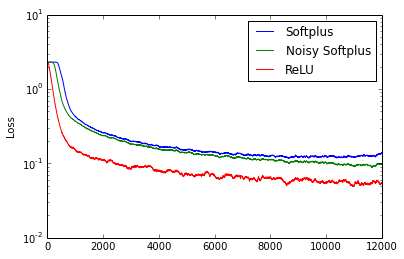

In [13]:
plt.clf()
er = frl['error']
print er.mean(axis=1)

sp = frl['sp']
plt.semilogy(np.mean(sp,axis=0),label='Softplus')
nsp = frl['nsp']
plt.semilogy(np.mean(nsp,axis=0),label='Noisy Softplus')
relu = frl['relu']
plt.semilogy(np.mean(relu,axis=0),label='ReLU')
plt.ylabel('Loss')
plt.legend(loc='upper right')
# plt.plot(error)
# cureve = plt.plot(range(rl.shape[1]), np.transpose(rl), linewidth='2')
# plt.legend(curve, ['Softplus', 'Noisy_Softplus', 'ReLU'],  loc='upper right') #, shadow=True loc='upper left'

plt.savefig('pic/8.pdf')

[  10   20   30   40   50   60   70   80   90  100  200  300  400  500  600
  700  800  900 1000 1100 1200]


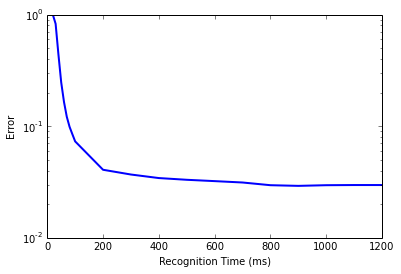

In [26]:
result = np.load('result_timewindow.npy')
result = np.append(result, [9704, 9703, 9703])
xa = range(10,100,10)
xb = range(100,1201,100)
print np.append(xa,xb)
plt.semilogy(np.append(xa,xb),1-result/10000.,linewidth=2)
plt.ylabel('Error')
plt.xlabel('Recognition Time (ms)')